## Portfolio Part 3

In this Portfolio task you will continue working with the movielens data collected by the GroupLens Research Project at the University of Minnesota. The columns in the dataset are a little bit different from the ones provided in the previous Portfolio tasks, where the 'rating' column is replaced by the 'feedback' column. There are two values regarding the 'feedback' with 1 indicating the user likes the corresponding movie; otherwise 0. 

The header of the csv file is shown below. 

| userId | age | gender | occupation| movieId | feedback | genre | timestamp |
    | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | 
    
#### Description of Fields

* __userId__ - the user's id
* __age__ - the user's age
* __gender__ - the user's gender
* __occupation__ - the user's occupation
* __movieId__ - the movie's id
* __feedback__ - the user's feedback towards the movie (1 means 'like'; 0 means 'dislike')
* __genre__ - the genre of the movie
* __timestamp__ - the timestamp indicating when the user rated the movie

Note that, a same user (i.e., a same userId) corresponds to a same age/gender/occupation; a same movie (i.e., a same movieId) corresponds to a same genre; a same user (i.e., a same userId) may like multiple movies and a same movie (i.e., a same movieId) may be preferred by multiple users.


Your high level goal in this notebook is to try to build and evaluate predictive models for feedback from available features - predict the value of the __feedback__ field in the data from some of the other fields. Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.

Note: you are not being evaluated on the ___accuracy___ of the model but on the ___process___ that you use to generate it. Please use a ___simple Logistic Regression model___ and ___one of the more advanced methods___ covered in recent weeks. Accordingly, discuss the performance of the simple and advanced methods.

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [91]:
df = pd.read_csv('movielens_data_feedback.csv')
df.head(10)

,userId,age,gender,occupation,movieId,feedback,genre,timestamp
0,196,49,M,writer,242,0,Comedy,881250949
1,186,39,F,executive,302,0,Crime,891717742
2,22,25,M,writer,377,0,Children,878887116
3,244,28,M,technician,51,0,Romance,880606923
4,166,47,M,educator,346,0,Drama,886397596
5,298,44,M,executive,474,1,War,884182806
6,115,31,M,engineer,265,0,Action,881171488
7,253,26,F,librarian,465,1,Adventure,891628467
8,305,23,M,programmer,451,0,Romance,886324817
9,6,42,M,executive,86,0,Drama,883603013


In [92]:
print("the length of the new data :",len(df))

the length of the new data : 100000


In [93]:
df.shape

(100000, 8)

In [94]:
df.describe()

,userId,age,movieId,feedback,timestamp
count,100000.00000,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,32.969850,425.530130,0.553750,8.835289e+08
std,266.61442,11.562623,330.798356,0.497105,5.343856e+06
min,1.00000,7.000000,1.000000,0.000000,8.747247e+08
25%,254.00000,24.000000,175.000000,0.000000,8.794487e+08
50%,447.00000,30.000000,322.000000,1.000000,8.828269e+08
75%,682.00000,40.000000,631.000000,1.000000,8.882600e+08
max,943.00000,73.000000,1682.000000,1.000000,8.932866e+08


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   userId      100000 non-null  int64 
 1   age         100000 non-null  int64 
 2   gender      100000 non-null  object
 3   occupation  100000 non-null  object
 4   movieId     100000 non-null  int64 
 5   feedback    100000 non-null  int64 
 6   genre       100000 non-null  object
 7   timestamp   100000 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 6.1+ MB


[Text(0.5, 1.0, 'count of every feedback')]

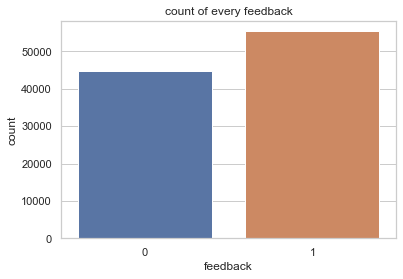

In [96]:
sns.countplot(x=df["feedback"]).set(title='count of every feedback')

# Logistical Regression model

In [97]:
#change desired columns into int type 
from sklearn.preprocessing import OrdinalEncoder


ord_enc = OrdinalEncoder(dtype=int)
df[["genre_code", "gender_code", "occupation_code"]] = ord_enc.fit_transform(df[["genre", "gender", "occupation"]])
df[["genre", "genre_code", "occupation", "occupation_code", "gender", "gender_code"]].head(11)

,genre,genre_code,occupation,occupation_code,gender,gender_code
0,Comedy,4,writer,20,M,1
1,Crime,5,executive,6,F,0
2,Children,3,writer,20,M,1
3,Romance,13,technician,19,M,1
4,Drama,7,educator,3,M,1
5,War,16,executive,6,M,1
6,Action,0,engineer,4,M,1
7,Adventure,1,librarian,10,F,0
8,Romance,13,programmer,14,M,1
9,Drama,7,executive,6,M,1


In [98]:
#convert our desired columns into numerical values

#gender
df['gender'] = df['gender'].astype('category')
df['gender'] = df['gender'].cat.codes

#occupation
df['occupation'] = df['occupation'].astype('category')
df['occupation'] = df['occupation'].cat.codes

#genre
df['genre'] = df['genre'].astype('category')
df['genre'] = df['genre'].cat.codes

df.drop(['gender','occupation','genre'], axis=1, inplace=True)

df.head

<bound method NDFrame.head of        userId  age  movieId  feedback  timestamp  genre_code  gender_code  \
0         196   49      242         0  881250949           4            1   
1         186   39      302         0  891717742           5            0   
2          22   25      377         0  878887116           3            1   
3         244   28       51         0  880606923          13            1   
4         166   47      346         0  886397596           7            1   
...       ...  ...      ...       ...        ...         ...          ...   
99995     880   13      476         0  880175444           4            1   
99996     716   36      204         1  879795543          14            0   
99997     276   21     1090         0  874795795          15            1   
99998      13   47      225         0  882399156           4            1   
99999      12   28      203         0  879959583          17            0   

       occupation_code  
0                   

## we will now use the RFE estimator to use the 3 best features we could find to build our logsitic regression model


In [160]:
#spliting our model into train and test
train1, test1 = train_test_split(df, test_size=0.2, random_state=142)
print("shape of the training data :",train1.shape)
print("shape of the testing data :",test1.shape)

shape of the training data : (80000, 8)
shape of the testing data : (20000, 8)


In [162]:
# Set up an experiment with the feedback data
feature_cols = np.array(['age', 'userId', 'movieId','timestamp','genre_code','gender_code','occupation_code'])
X = df[feature_cols]
y = df['feedback']

#this split of data is only for the RFE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=142)


In [117]:
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()
selector = RFE(estimator, 3)  # select 3 features for us
selector = selector.fit(X, y)

supp = selector.get_support()
print("Selected features:", feature_cols[supp])
print("Coeffs:", selector.estimator_.coef_)
# test the model
predicted = selector.predict(X)
print("MSE:", mean_squared_error(y, predicted))
print("R^2:", r2_score(y, predicted))

Selected features: ['age' 'genre_code' 'gender_code']
Coeffs: [ 0.00164585  0.00410019 -0.00268293]
MSE: 0.2463256197460694
R^2: 0.0031779967405553


In [118]:
#build our logistic model with our desired features to predict feedback
feature_cols=['age','genre_code','gender_code']
X_train = train1[feature_cols]
y_train = train1['feedback']
X_test = test1[feature_cols]
y_test = test1['feedback']

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
print(X_train.head())
print(y_train.head())

X_train shape:  (80000, 3)
y_train shape:  (80000,)
X_test shape:  (20000, 3)
y_test shape:  (20000,)
       age  genre_code  gender_code
36772   51           4            1
43891   46           7            1
52044   29           4            1
14810   60          12            1
64521   37          13            0
36772    0
43891    1
52044    0
14810    0
64521    1
Name: feedback, dtype: int64


In [119]:
# Training Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [120]:
# Doing predictions on train and test set
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

In [121]:
# Evaluate the performance of your trained model
print("Accuracy score on training set: ", accuracy_score(y_train, y_hat_train))
print("Accuracy score on testing set: ", accuracy_score(y_test, y_hat_test))



Accuracy score on training set:  0.55155
Accuracy score on testing set:  0.5572


<BarContainer object of 2 artists>

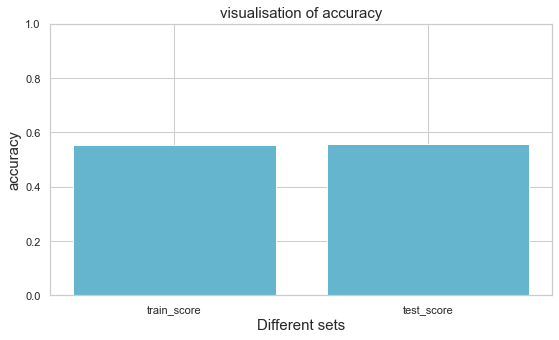

In [122]:
#place our accuracy scores in our 2 new variables

train_score= accuracy_score(y_train, y_hat_train)
test_score=accuracy_score(y_test, y_hat_test)
 
#creat a new dataframe to graph our scores
accuracy_df = pd.DataFrame({'accuracy score': [train_score,test_score]}, index=['training_accuracy', 'testing_accuracy'])

#plot our graphs
sns.set(style="whitegrid")
plt.figure(figsize=(9,5))
plt.ylim(0,1)
plt.xlabel('Different sets', size=15)
plt.ylabel('accuracy', size=15)
plt.title("visualisation of accuracy", size=15)
plt.bar(data=accuracy_df, height='accuracy score', x=['train_score', 'test_score'], color='c')



### The accuracy score of both sets are similar however, they are also low scores of around 0.55 which is slightly above the threshhold of 0.5 however it is still considered low

In [123]:
# Checking confusion matrix
print("Confusion matrix on test set: ")
print(confusion_matrix(y_test, y_hat_test))
print("Confusion matrix on train set: ")
print(confusion_matrix(y_train, y_hat_train))

Confusion matrix on test set: 
[[  151  8693]
 [  163 10993]]
Confusion matrix on train set: 
[[  570 35211]
 [  665 43554]]


## The confusion matrix for both sets also shows that the results are slightly above the threshhold whereas there is still alot of false results showing up therefore the logistic model yields acceptable results whatsoever they are still considered low.

# K-nearest neighbour 

In [156]:
feature_cols = np.array(['age', 'userId', 'movieId','timestamp','genre_code','gender_code','occupation_code'])
X = df[feature_cols]
y = df['feedback']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [157]:
# Create and training a KNN classifier model
clf = KNeighborsClassifier(n_neighbors = 11)
clf.fit(X_train, y_train)

# Use the model to predict testing data
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print('Testing accuracy is: ', accuracy)

Testing accuracy is:  0.6666


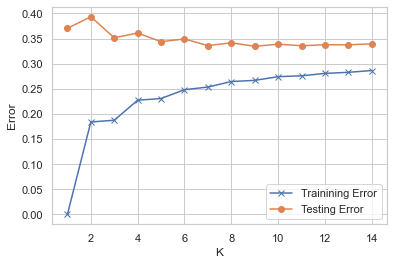

In [147]:
training_error=list()
testing_error=list()

for i in range(1, 15):
    clf = KNeighborsClassifier(n_neighbors = i)
    clf.fit(X_train, y_train)
    training_error.append(1.0-accuracy_score(clf.predict(X_train), y_train))
    testing_error.append(1.0-accuracy_score(clf.predict(X_test), y_test))

# Plot the relationship
plt.plot(range(1, 15), training_error, marker='x', label='Trainining Error')
plt.plot(range(1, 15), testing_error, marker='o', label='Testing Error')
plt.xlabel('K')
plt.ylabel('Error')
plt.legend(loc='best')
plt.show()

In [148]:
# Define search space for parameters
parameter_grid = {'n_neighbors': range(1, 12)}

# Create the machine learning model
knn_clf = KNeighborsClassifier()
clf = GridSearchCV(knn_clf, parameter_grid, scoring='accuracy', cv=10)
clf.fit(X_train, y_train)

# Identify the best parameter(s)
print('Best K value: ', clf.best_params_['n_neighbors'])
print('The accuracy: ', clf.best_score_)

Best K value:  11
The accuracy:  0.66265


In [149]:
# Create a KNN classifier model and use k-fold cross validation for testing accuracy estimation
clf = KNeighborsClassifier(n_neighbors = 11)
scores = cross_val_score(clf, X_train, y_train, cv=10)
print('Accuracy for each round: \n', scores)
print('Average accuracy: %.4f +- %.4f' % (scores.mean(), scores.std()))

Accuracy for each round: 
 [0.660875 0.66     0.6785   0.657875 0.6625   0.660875 0.664875 0.67075
 0.657625 0.652625]
Average accuracy: 0.6626 +- 0.0070


## comparison of models

<BarContainer object of 2 artists>

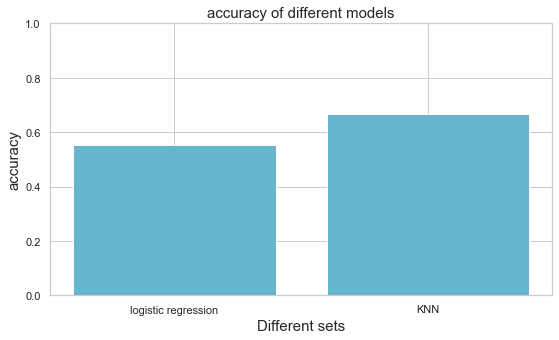

In [159]:
#create a dataset with the accuracy score of both models
accuracy_df = pd.DataFrame({'accuracy score': [train_score,accuracy]}, index=['training_accuracy', 'knn'])


#visualise the models
sns.set(style="whitegrid")
plt.figure(figsize=(9,5))
plt.ylim(0,1)
plt.xlabel('Different models', size=15)
plt.ylabel('accuracy', size=15)
plt.title("accuracy of different models", size=15)
plt.bar(data=accuracy_df, height='accuracy score', x=['logistic regression', 'KNN'], color='c')



## the KNN model had an accuracy of around 0.66 which is acceptable meanwhile the logistic regression model had an accuracy of around 0.55 which is greatly lower than the KNN method and therefore the KNN method is the more suitable one for this data.